In [47]:
import pandas as pd
import matplotlib.pyplot as plt
base_Edu=pd.read_parquet("D:\\2AD ENSAE\\Projet de statistique appliquée\\Dossier travail\\base_Edu.parquet")
base_Edu

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1306435320134834461,0,-4,2021-02-25 10:11:13.000000,7,0,0,0,11,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
199996,5732789662758255879,0,0,2017-12-06 15:46:14.000000,45,0,0,0,7,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199997,3325713948509922176,17,9,2019-07-21 18:24:08.000000,229,0,0,0,83,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199998,7446387329160512320,68,57,2021-10-28 19:09:58.000000,172,0,242,0,310,120,...,0,0,0,15,0,0,0.0,100.0,0.0,0.0


In [48]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 477 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(254), datetime64[us](1), float64(150)
memory usage: 450.9 MB
None


La base de données compte donc 477 variables dont 72 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 221 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera essentiellement ici aux données erronnées et valeurs manquantes. La nature de nos variables c'est à dire leur sens laisse supposer des valeurs négatives comme potentielles valeurs erronées pour nos variables numérique (int + float+ datetime). Aucune opération ne sera faite au niveau des booléen concernant les données erronées puisque leur type impose déjà les valeurs possibles. 

In [49]:
neg=(base_Edu.select_dtypes(exclude="datetime")<0).sum()/len(base_Edu)
print(neg[neg>0])
print("Les types concernés par les valeurs négatives sont: ",base_Edu[neg[neg>0].index].dtypes.value_counts())


unique_learner_id                               0.49958
days_between_order_and_first_activity           0.10299
days_between_first_activity_and_exam            0.03113
days_between_order_and_exam                     0.00052
avg_self_assessment_gap                         0.24112
exam_series_increment_avg                      0.217945
delay_annulation_lesson_days_min               0.000025
delay_annulation_lesson_days_avg               0.000015
score_pct__mean_change                         0.228525
score_pct__mean_second_derivative_central       0.45819
score_pct__skewness                             0.57913
score_pct__kurtosis                            0.398365
score_pct__fft_aggregated__aggtype_kurtosis    0.001985
score_pct__linear_trend__attr_intercept        0.000005
score_pct__linear_trend__attr_slope            0.199035
dtype: Float64
Les types concernés par les valeurs négatives sont:  float64    10
Int64       5
Name: count, dtype: int64


15 variables numériques présentent donc des valeurs négatives potentiellement erronnées.Ces valeurs négatives n'ont pas de raison d'être présentent dans la base.  Seul les variables de types **int** et **float** sont concernées. On laisse de coté la variable **unique_learner_id** qui représente l'identifiant de notre base qui ne nous sera d'ailleurs d'aucune utilité pour nos analyses. On pourrait penser à supprimer les observations correspondantes au valeurs manqantes. Mais cela entrainerait une perte considérable d'informations. La variable **score_pct__skewness** présente à elle seul 57%  de valeurs négatives. On risque donc de perdre environ 60% des observations voire plus si on décide de supprimer des observations associés. On choisit ici de remplacer ces valeurs par la médiane de la variable correspondante pour éviter de distordre significativement la structure de nos données. 

In [ ]:
#Récupération des variables concernées sauf l'identifiant
neg=neg.drop("unique_learner_id")

In [ ]:
def replace_negatives_with_median(df):
    # Filtrer uniquement les colonnes numériques
    numerical_df = df.select_dtypes(include=['number'])
    
    # Remplacer les valeurs négatives par la médiane
    for column in numerical_df.columns:
        # Calculer la médiane sans les valeurs négatives
        median_without_negatives = numerical_df.loc[numerical_df[column] >= 0, column].median()
        
        # Remplacer les valeurs négatives par cette médiane
        df[column] = df[column].apply(lambda x: median_without_negatives if x < 0 else x)
    
    return df

# Application de la fonction
base_Edu[neg[neg>0].index] = replace_negatives_with_median(base_Edu[neg[neg>0].index])


C:\Users\HP\AppData\Local\Temp\ipykernel_5496\1786813593.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: median_without_negatives if x < 0 else x)
C:\Users\HP\AppData\Local\Temp\ipykernel_5496\1786813593.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: median_without_negatives if x < 0 else x)
C:\Users\HP\AppData\Local\Temp\ipykernel_5496\1786813593.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

DataFrame après remplacement des valeurs négatives :


,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,3838161406066513919,41,0.0,2017-12-17 15:00:23.000000,265,0,3,0,3,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
1,5829430568065349352,0,0.0,2022-07-07 12:02:53.000000,27,0,0,0,11,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
2,7677180318050051984,787,788.0,2022-05-10 01:35:49.000000,295,0,0,0,73,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
3,-5150597998144597550,615,616.0,2024-04-18 04:56:03.262330,138,0,0,0,75,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
4,969323468959211246,169,170.0,2019-03-19 12:32:56.000000,554,0,0,0,41,120,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1306435320134834461,0,1.0,2021-02-25 10:11:13.000000,7,0,0,0,11,240,...,0,0,0,1,0,0,0.0,100.0,0.0,0.0
199996,5732789662758255879,0,0.0,2017-12-06 15:46:14.000000,45,0,0,0,7,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199997,3325713948509922176,17,9.0,2019-07-21 18:24:08.000000,229,0,0,0,83,<NA>,...,0,0,0,0,0,1,0.0,0.0,0.0,100.0
199998,7446387329160512320,68,57.0,2021-10-28 19:09:58.000000,172,0,242,0,310,120,...,0,0,0,15,0,0,0.0,100.0,0.0,0.0


Interessons nous maintenant aux valeurs manquantes. 

In [3]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.743390
std        0.279055
min        0.047720
25%        0.666710
50%        0.842345
75%        0.918625
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [4]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variable de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variable de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variable de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variable de type datetime ont des valeurs manquantes")

48  variable de type int ont des valeurs manquantes
103  variable de type float ont des valeurs manquantes
253  variable de type boolean ont des valeurs manquantes
0  variable de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [5]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.903116
std        0.072136
min        0.695085
25%        0.837765
50%        0.883305
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comporte pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [6]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [7]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.475770
std        0.292138
min        0.047720
25%        0.184915
50%        0.483995
75%        0.736010
max        0.941710
dtype: float64

Pour les variables quantitatives, la distribution des valeurs manquantes est plus étendue. On enregistre 151 variables qualitatives avec valeurs manquantes. On a un minimum de 4% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables avant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [8]:
miss_quant[miss_quant<=0.20].describe()

count    118.000000
mean       0.054362
std        0.074368
min        0.000000
25%        0.000000
50%        0.000000
75%        0.106310
max        0.194530
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (118 sont conservées sur un total de 151)

In [9]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [10]:
base_Edu.isnull().any().sum()

0

Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

## ACP

In [11]:
#base_acp=base_Edu.select_dtypes(include=["int","float"]).drop(columns="unique_learner_id")

In [ ]:
#pip install ploty

^C


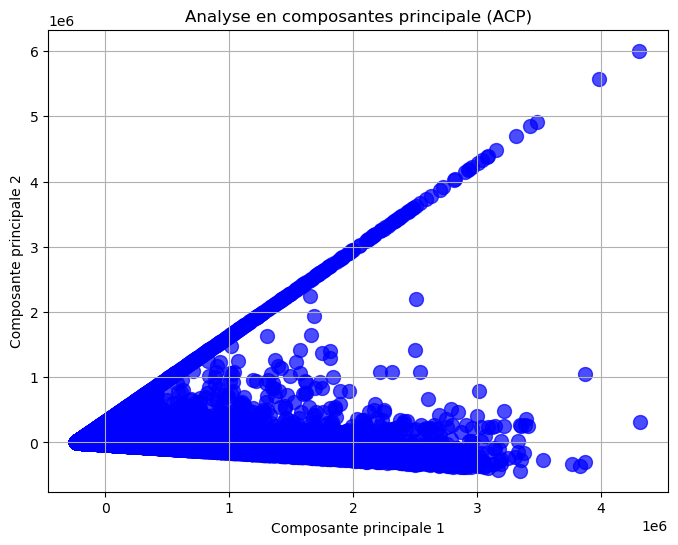

Variance expliquée par chaque composante : [8.69729429e-01 1.02347379e-01 2.59771754e-02 9.89118816e-04
 4.96605004e-04 3.16477842e-04 8.54157507e-05 1.91710053e-05
 9.64111652e-06 8.29175872e-06]


In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
 
# # Étape 1 : Identifier les colonnes catégorielles
# #base_acp=base_Edu.select_dtypes('float').drop(columns="unique_learner_id")
# categorical_columns = base_acp.select_dtypes(include=['object', 'category']).columns
# numerical_columns = base_acp.select_dtypes(include=['int64', 'float64']).columns

# # Étape 2 : Encodage One-Hot des colonnes catégorielles
# encoder = OneHotEncoder(sparse_output=False)
# encoded_categorical = encoder.fit_transform(base_acp[categorical_columns])
# modalities = encoder.get_feature_names_out(categorical_columns)  # Noms des modalités encodées

# # Étape 3 : Combiner les colonnes numériques et encodées
# import numpy as np
# if numerical_columns.any():
#     combined_data = np.hstack((base_acp[numerical_columns].values, encoded_categorical))
# else:
#     combined_data = encoded_categorical

# #Centrer et réduire les variables 
# scaler=StandardScaler()
# base_acp=scaler.fit_transform(base_acp)

# # Étape 4 : Application de l'ACP
# pca = PCA(n_components=10)
# components = pca.fit_transform(combined_data)
 
# # Créer un DataFrame avec les trois premiers axes
# pca_df = pd.DataFrame(
#     components,
#     columns=['PCA1', 'PCA2', 'PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']
# )

# # Étape 5 : Visualisation des composantes principales
# plt.figure(figsize=(8, 6))
# plt.scatter(components[:, 0], components[:, 1], s=100, alpha=0.7, c='blue')
# plt.title('Analyse en composantes principale (ACP)')
# plt.xlabel('Composante principale 1')
# plt.ylabel('Composante principale 2')
# plt.grid()
# plt.show()

# # Étape 6 : Variance expliquée par chaque composante
# print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

Axe 1: 86.97% de variance expliquée
Axe 2: 10.23% de variance expliquée
Axe 3: 2.60% de variance expliquée
Axe 4: 0.10% de variance expliquée
Axe 5: 0.05% de variance expliquée
Axe 6: 0.03% de variance expliquée
Axe 7: 0.01% de variance expliquée
Axe 8: 0.00% de variance expliquée
Axe 9: 0.00% de variance expliquée
Axe 10: 0.00% de variance expliquée


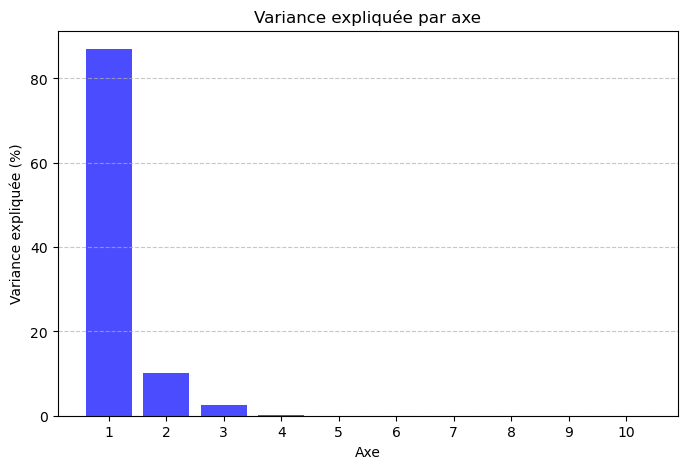

In [14]:
# # Étape 3 : Récupérer la variance expliquée
# explained_variance = pca.explained_variance_ratio_

# # Afficher la variance expliquée par axe
# for i, var in enumerate(explained_variance, start=1):
#     print(f"Axe {i}: {var * 100:.2f}% de variance expliquée")


# import matplotlib.pyplot as plt

# # Graphique de la variance expliquée
# plt.figure(figsize=(8, 5))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='blue', alpha=0.7)
# plt.title('Variance expliquée par axe')
# plt.xlabel('Axe')
# plt.ylabel('Variance expliquée (%)')
# plt.xticks(range(1, len(explained_variance) + 1))
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

## FAMD

In [106]:

# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri

# # Activer la conversion automatique entre pandas et R
# pandas2ri.activate()

# # Importer un dataframe Pandas en Python
# import pandas as pd


# # Charger les données dans R
# ro.globalenv['data'] = pandas2ri.py2rpy(base_famd)

# # Exécuter le code R
# #!R -e "install.packages("FactoMineR")"
# ro.r('''
# #.libPaths(c("/home/onyxia/R/x86_64-pc-linux-gnu-library/4.1", .libPaths()))
# install.packages("FactoMineR")
# install.packages("factoextra")
# library(FactoMineR)
# library(factoextra)
# result <- FAMD(data, ncp = 2, graph = FALSE)


# # Sauvegarder le graphique des individus --- ne marche pas
# png("famd_individus.png", width = 800, height = 600)
# fviz_famd_ind(result, repel = TRUE) # Graphe des individus
# dev.off()

# # Sauvegarder le graphique des variables --- ne marche pas
# png("famd_variables.png", width = 800, height = 600)
# fviz_famd_var(result, repel = TRUE) # Graphe des variables
# dev.off()
# res <-summary(result)
# result_df <- as.data.frame(result$ind$coord) # Récupérer les coordonnées des individus
# result_var_df <- as.data.frame(result$var$coord) # Récupérer les coordonnées des individus
# ''')

# # Récupérer les résultats en Python
# result_df = ro.r('result_df')
# result_var_df = ro.r('result_var_df')
# res = ro.r('res')
# print(res)

# result_df = pandas2ri.rpy2py(result_df)
# result_var_df = pandas2ri.rpy2py(result_var_df)
# print("Résultats de la FAMD :\n", result_df)

0